Steps:  
* [Bin the country/language variables](#Bin-the-country/language-variables)
* [Bin the age variables](#Bin-the-age-variables)
* [Group/bin income variables](#Group/bin-income-variables)
* [Drop dupes of education](#Drop-dupes-of-education)
* [Bin number of people in household](#Bin-number-of-people-in-household)
* [Consider date variables - bin by season?](#Date-variables)
* [Revisit missing](#Remaining-missing-values)
* Look for outliers
* [One-hot/Label Encoding](#Onehot/label-encoding)
* [Export](#Export-data)

In [790]:
# Import packages
import pandas as pd
import numpy as np
import statistics
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import pycountry_convert as pc
from sklearn.linear_model import LinearRegression

# Set options
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [791]:
# Import data
train = pd.read_csv("../01-data/train.csv", low_memory = False)
test = pd.read_csv("../01-data/test.csv", low_memory = False)

# Custom data
codebook = pd.read_csv("../01-data/codebook_compact.csv", low_memory = False) # OG codebook+dtypes from codebook_long

# Fill missing responses with "." so that they can be counted and categorized as missing later on
train_no_blanks = train.fillna('.')
test_no_blanks = test.fillna('.')

### Bin the country/language variables

In [792]:
# Dealing with country vars on a case-by-case basis
cat_cols = ['v17', "v20", "v25", "v78", "v154", "v155", "v161", "cntry"]
cat_df = train[cat_cols]

In [793]:
## V17: Country of Birth

# Drop 99, 2, 4, 3, 77, 6
to_drop = ['99', '2', '4', '3', '77', '6', '88']
train['v17'] = train['v17'].replace(to_drop, ".")

def convert_country(country):
    try:
        return(pc.country_alpha2_to_continent_code(country))
    except:
        return(country)

train['v17'] = train['v17'].apply(lambda x: convert_country(x))

# Only one observation is from TL, and none exist in the test set. Drop ID = 2441
train = train[train.v17 != 'TL']

train['v17'].value_counts()

66    26687
EU     1925
AS      537
AF      433
.       229
SA      144
NA      113
OC       11
Name: v17, dtype: int64

In [794]:
## V20: Region

# Country code + more specific region code. Convert to just country
# After stripping specific region code, only 6% of obs have a different entry here than for 'cntry'. Drop this column.
train = train.drop('v20', axis = 1)

In [795]:
## V25: Citizenship

# Drop 65, 99, 6, convert rest to continents
to_drop = ['65', '99', '6', '88']
train['v25'] = train['v25'].replace(to_drop, '.')
train['v25'] = train['v25'].apply(lambda x: convert_country(x))

In [796]:
## V78: Country of birth, father AND V161: Country of birth, mother

# Drop errors, convert rest to continents
to_drop = ['99', '88', '2', '4', '3', '77', '6']
train['v78'] = train['v78'].replace(to_drop, '.')
train['v78'] = train['v78'].apply(lambda x: convert_country(x))

train['v161'] = train['v161'].replace(to_drop, '.')
train['v161'] = train['v161'].apply(lambda x: convert_country(x))

In [797]:
## V154: Language most often spoken at home: first mentioned

# Drop errors
to_drop = ['999','888','777']
train['v154'] = train['v154'].replace(to_drop, '.')

# Leaving ENG and GER as is 
missing = ["."]
GER = ["GER"]
ENG = ["ENG"]
eur = ["FRE","DUT","SPA","HUN","POR","GSW","CAT","ITA","GLG","ALB","FRS","HRV","BAQ","ROA","GLE",
       "GEM","CPP","FRM","GRE","WEL","ROH","BEL","FAO","SRN","NAP","AST","FRO"]
bal = ["CZE", "LIT"]
afr = ["AMH","SOM","BER","MLG","TIR","MAN","LIN","WOL","BAM","AKA","SWA","SUX","SUS","SNK","TIG"]
nor = ["FIN","SWE","DAN","NOR","EST","ICE"]
asia = ["CHI","VIE","THA","MAY","TAI","TIB","IND","JPN","LAO"]
southa = ["URD","HIN","TAM","GUJ","BEN","MAL","PAN","TEL","CPF"]
mideast = ["HEB","ARA","TUR","KUR","PER","ARM","IRA","YID","SYR","AZE","UZB","TGK","KAB","EGY","ABK","GEO"]
slav = ["POL","SLV","RUS","SRP","BOS","RUM","HRV","SLO","ROM","BUL","UKR","SLA","LAV","MDR"]
oth = ["APA","PAP","MIS","TGL","NEP","FIL","MON"]

languages = {language: 'EUR' for language in eur}
languages.update({language: '.' for language in missing})
languages.update({language: 'GER' for language in GER})
languages.update({language: 'ENG' for language in ENG})
languages.update({language: 'BAL' for language in bal})
languages.update({language: 'AFR' for language in afr})
languages.update({language: 'NOR' for language in nor})
languages.update({language: 'ASIA' for language in asia})
languages.update({language: 'SOUTHA' for language in southa})
languages.update({language: 'MIDEAST' for language in mideast})
languages.update({language: 'SLAV' for language in slav})
languages.update({language: 'OTHER' for language in oth})

train['v154'] = train['v154'].map(languages)

train['v154'].value_counts(normalize = True)

EUR        0.260381
NOR        0.203364
GER        0.120316
ENG        0.116061
SLAV       0.113967
BAL        0.106652
MIDEAST    0.065860
.          0.008079
SOUTHA     0.001895
AFR        0.001496
OTHER      0.001031
ASIA       0.000898
Name: v154, dtype: float64

In [798]:
## V155: Language most often spoken at home: second mentioned

# Assuming 0 means no other language, and 999, 888, 777 are missing
to_drop = ['999','888','777']
train['v155'] = train['v155'].replace(to_drop, '.')

## Check if any weren't present in the previous question
lang_v154 = ["GER","ENG","FRE","CZE","LIT","FIN","POL","DUT","SWE","HEB","SPA",
             "HUN","DAN","NOR","POR","EST","SLV","RUS","GSW","ARA","CAT","TUR",
             "ITA","GLG","SRP","BOS","ALB","FRS","RUM","KUR","HRV","BAQ","URD",
             "PER","AMH","APA","ROA","CHI","HIN","ARM","GLE","SOM","SLO","IRA",
             "TAM","GEM","GUJ","ROM","CPP","FRM","GRE","WEL","VIE","BUL","UKR",
             "YID","BER","PAP","MIS","BEN","SLA","LAV","MAL","THA","TGL","NEP",
             "MAY","SYR","AZE","UZB","PAN","TGK","MLG","ROH","TIR","MAN","TAI",
             "LIN","KAB","EGY","BEL","WOL","BAM","TIB","AKA","SWA","IND","SUX",
             "TEL","FAO","JPN","SRN","SUS","ICE","SNK","FIL","ABK","GEO","TIG",
             "NAP","AST","FRO","LAO","CPF","MON","MDR"]

lang_v155 = train['v155'].unique().tolist()

new_languages = [language for language in lang_v155 if language not in lang_v154]

# New language dict: leaving ENG and GER as is 
none = ['0']
missing = ["."]
GER = ["GER"]
ENG = ["ENG"]
eur = ["FRE","DUT","SPA","HUN","POR","GSW","CAT","ITA","GLG","ALB","FRS","HRV","BAQ","ROA","GLE",
       "GEM","CPP","FRM","GRE","WEL","ROH","BEL","FAO","SRN","NAP","AST","FRO","ENM","OCI","BRE",
       "NDS","WLN","VOL","MWL"]
bal = ["CZE", "LIT", "MAC", "CSB"]
afr = ["AMH","SOM","BER","MLG","TIR","MAN","LIN","WOL","BAM","AKA","SWA","SUX","SUS","SNK","TIG",
       "EWE","RUN","IBO","YOR","FON","KON","DYU","KIN","NIC","NDE","HER","KIK"]
nor = ["FIN","SWE","DAN","NOR","EST","ICE", 'SMN']
asia = ["CHI","VIE","THA","MAY","TAI","TIB","IND","JPN","LAO"]
southa = ["URD","HIN","TAM","GUJ","BEN","MAL","PAN","TEL","CPF", "MAR"]
mideast = ["HEB","ARA","TUR","KUR","PER","ARM","IRA","YID","SYR","AZE","UZB","TGK","KAB","EGY","ABK","GEO"]
slav = ["POL","SLV","RUS","SRP","BOS","RUM","HRV","SLO","ROM","BUL","UKR","SLA","LAV","MDR"]
oth = ["APA","PAP","MIS","TGL","NEP","FIL","MON","ZXX","TPI","GRN","SGN","HUP","NAH","HAT","CAD","PHI","MAO"]

 
languages = {language: 'EUR' for language in eur}
languages.update({language: '0' for language in none})
languages.update({language: '.' for language in missing})
languages.update({language: 'GER' for language in GER})
languages.update({language: 'ENG' for language in ENG})
languages.update({language: 'BAL' for language in bal})
languages.update({language: 'AFR' for language in afr})
languages.update({language: 'NOR' for language in nor})
languages.update({language: 'ASIA' for language in asia})
languages.update({language: 'SOUTHA' for language in southa})
languages.update({language: 'MIDEAST' for language in mideast})
languages.update({language: 'SLAV' for language in slav})
languages.update({language: 'OTHER' for language in oth})

# Map langauges to their groups
train['v155'] = train['v155'].map(languages)

train['v155'].value_counts(normalize = True)

0          0.792447
.          0.061604
EUR        0.041158
ENG        0.027827
NOR        0.021510
SLAV       0.019449
MIDEAST    0.017388
GER        0.012002
BAL        0.002161
AFR        0.001662
OTHER      0.001130
ASIA       0.000831
SOUTHA     0.000831
Name: v155, dtype: float64

### Bin the age variables

In [799]:
## V3: Age of respondent, calculated

missing_age = round(len(train[train['v3'] == '.a'])/len(train) * 100, 2)
print(str(missing_age) + "% of the ages are missing.")

0.24% of the ages are missing.


In [800]:
# Using EDA notebook, the highest positive and negatively linearly correlated vars with Age (v3):
# Positive: v217, v163, v218, v103, v99
# Negative: v54, v196, v208, v100, v159	
cols = ['v3','v217','v218', 'v54']

regress_age = train[cols]
train_lr = regress_age[regress_age['v3'] != '.a']
test_lr = regress_age[regress_age['v3'] == '.a']

for col in cols:
    train_lr[col] = pd.to_numeric(train[col], errors = 'coerce')

# Drop all na
train_lr = train_lr.dropna()

X_train = train_lr.loc[:, train_lr.columns != 'v3']
y_train = train_lr['v3']

# Linear regression
regressor = LinearRegression()  
regressor.fit(X_train, y_train) 

del test_lr['v3']
test_lr = test_lr.replace(['.a', '.b', '.c', '.d'], np.nan).dropna()

test_lr["predicted_age"] = regressor.predict(test_lr)

# Gives R2 score of 0.63 but better than imputation by mean
# metrics.r2_score(label, train_no_na["predicted_age"])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [801]:
# Filling in missing values with predicted age
index_predicted = test_lr.drop(['v217','v218', 'v54'], axis = 1).index
index_missing = train[train['v3'] == '.a'].index

train = train.join(test_lr['predicted_age'])
train['v3_imputed'] = np.where(train['v3'] == '.a', train['predicted_age'], train['v3']).astype("float64")

# Delete other versions of age
del train['v3']
del train['predicted_age']

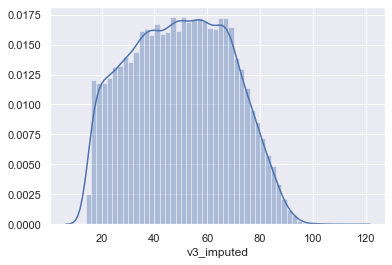

In [802]:
# Plot age distribution
sns.set(color_codes=True)
sns.distplot(train['v3_imputed'].astype("float64"));

# (37.0, 44.0]
# (23.0, 31.0]
# (44.0, 50.0]
# (61.0, 67.0]
# (55.0, 61.0]
# (13.999, 23.0]
# (74.423, 114.0]
# (67.0, 74.423]
# (31.0, 37.0]
# (50.0, 55.0]

bin_labels = [1,2,3,4,5,6,7,8,9,10]
train['v3_binned'] = pd.qcut(train['v3_imputed'], q=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1], labels=bin_labels)

del train['v3_imputed']

### Group/bin income variables

In [803]:
# Drop v102 as it is almost the same as v103 but with less information
del train['v102']

### Drop dupes of education

In [804]:
# Drop v57, v59, v61, v63 as v56, v58, v60, v62 gives the same information but mapped to categories
del train['v57']
del train['v59']
del train['v61']
del train['v63']

0.93% of the years are missing.


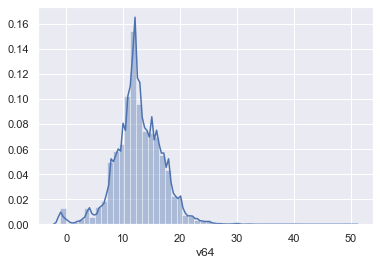

In [805]:
# V64: Years of full time education completed

# Combine all missing
train['v64'] = pd.to_numeric(train['v64'], errors='coerce')

missing_age = round(len(train[train['v64'].isnull()])/len(train) * 100, 2)
print(str(missing_age) + "% of the years are missing.")

# Plot distribution
sns.distplot(train['v64'].fillna(-1));

# Fill with mean bc I'm tired
train['v64'] = pd.to_numeric(train['v64'], errors = 'coerce')
mean_years = np.nanmean(train['v64'])
train['v64'] = train['v64'].fillna(mean_years)

In [806]:
## Now bin education
train['v64'].describe()

bin_labels = [1,2,3,4,5]
train['v64_binned'] = pd.qcut(train['v64'], q=[0,0.2,0.4,0.6,0.8,1], labels=bin_labels)

In [807]:
train['v64_binned'].value_counts()
del train['v64']

### Bin number of people in household

In [808]:
## V100: Number of people living regularly as member of household
# Group everything more than 6 into "6+", i.e. 6

# Combine all missing
train['v100'] = pd.to_numeric(train['v100'], errors='coerce')

missing_age = round(len(train[train['v100'].isnull()])/len(train) * 100, 2)
print(str(missing_age) + "% of the numbers are missing.")

# Fill with mean
mean_years = np.nanmean(train['v100'])
train['v100'] = train['v100'].fillna(mean_years).astype("int64")

# Grouping large values
train['v100_grouped'] = np.where(train['v100'] > 6, 6, train['v100']).astype("int64")
train['v100_grouped'].value_counts()

0.28% of the numbers are missing.


2    10553
1     6387
3     5414
4     4894
5     1829
6     1002
Name: v100_grouped, dtype: int64

### Date variables

Create start/end time_of_day, season, and bin interview length (minutes)

In [809]:
# v128: End of interview, month
# v129: Start of interview, month
# End and start of interview are only not equal for 0.18% of observations
# We keep v129 since there are no missing
del train['v128']

# Define: 3-5 = Spring, 6-8 = Summer, 9-11 = Autumn, 12-2 = Winter - in Germany
winter = [12,1,2]
spring = [3,4,5]
summer = [6,7,8]
autumn = [9,10,11]

# Dictionary for seasons
seasons = {season: 'WI' for season in winter}
seasons.update({season: 'SP' for season in spring})
seasons.update({season: 'SU' for season in summer})
seasons.update({season: 'AU' for season in autumn})

# Map langauges to their groups
train['start_interview_season'] = train['v129'].map(seasons)
train['start_interview_season'].value_counts(normalize = True)

# Delete original variable
del train['v129']

In [810]:
# v126: end of interview, hour
# v130: start of interview, hour

# Impute with mean
train['v126'] = pd.to_numeric(train['v126'], errors='coerce')
train['v126'] = train['v126'].fillna(np.nanmean(train['v126'])).astype('int64')
train['v130'] = pd.to_numeric(train['v130'], errors='coerce')
train['v130'] = train['v130'].fillna(np.nanmean(train['v130'])).astype('int64')

bin_labels = [1,2,3,4,5]
train['v126_binned'] = pd.qcut(train['v126'], q=[0,0.2,0.4,0.6,0.8,1], labels=bin_labels)
train['v130_binned'] = pd.qcut(train['v130'], q=[0,0.2,0.4,0.6,0.8,1], labels=bin_labels)

# Delete original variables
del train['v126']
del train['v130']

In [811]:
# v132: Interview length in minutes - bin in quantiles
pd.qcut(train['v132'], q = 10).value_counts()

bin_labels = [1,2,3,4,5,6,7,8,9,10]
train['v132_binned'] = pd.qcut(train['v132'], q=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1], labels=bin_labels)

# Delete original variable
del train['v132']

### Remaining missing values

Same as before, we find columns with over some % '.' variables and drop them

In [812]:
# Treating missing 
train_nodots = train.replace([".", ".a", ".b", ".c", ".d"], [np.nan, np.nan, np.nan, np.nan, np.nan])
percent_missing_nodots = train_nodots.isnull().sum() * 100 / len(train_nodots)
missing_value_df_nodots = pd.DataFrame({'column_name': train_nodots.columns,
                                 'percent_missing': percent_missing_nodots})

# Columns where % missing > some percent
percent = 50
cols_missing = missing_value_df_nodots[missing_value_df_nodots.percent_missing > percent]
n_cols_missing = len(missing_value_df_nodots[missing_value_df_nodots.percent_missing > percent])
print("There are " + str(n_cols_missing) + " features with over " + str(percent) + "% missing.")

# Attach short desc for more context
codebook_labels = ['Variable', "Label"]
missing = cols_missing.merge(codebook[codebook_labels], left_on = 'column_name', right_on = "Variable", how = "left")
missing.sort_values(by = "percent_missing", ascending = False)

There are 63 features with over 50% missing.


,column_name,percent_missing,Variable,Label
55,v262,99.996675,v262,Year of birth of thirteenth pe...
41,v207,99.996675,v207,Thirteenth person in household...
8,v89,99.996675,v89,Gender of thirteenth person in...
30,v195,99.996675,v195,Thirteenth person in household...
54,v261,99.983377,v261,Year of birth of twelfth perso...
7,v88,99.983377,v88,Gender of twelfth person in ho...
40,v206,99.980053,v206,Twelfth person in household: r...
29,v194,99.980053,v194,Twelfth person in household: r...
53,v260,99.940158,v260,Year of birth of eleventh pers...
6,v87,99.933508,v87,Gender of eleventh person in h...


In [813]:
# Try keeping ALL of them and imputing with -1 for now.
dots = [".", ".a", ".b", ".c", ".d", np.nan]
train_imputed = train.replace(dots, [-1, -1, -1, -1, -1, -1])

### One-hot/Label encoding

In [817]:
one_hot = ['v17','v25','v78','v161', 'v154', 'v155', 'start_interview_season']
train_encoded = pd.get_dummies(train_imputed, prefix=one_hot, columns=one_hot)

### Export data

In [819]:
train_encoded.to_csv("train_FE.csv")